In [1]:
# Machine learning and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import scipy as sp
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import csv
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import wordcloud
import re

### Loading Data

In [3]:
# Load the cleaned data
df = pd.read_csv('../enron_emails_cleaned.csv')

In [4]:
# Get basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495547 entries, 0 to 495546
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Date        495547 non-null  object
 1   From        495547 non-null  object
 2   To          495547 non-null  object
 3   Subject     476725 non-null  object
 4   X-From      494247 non-null  object
 5   X-To        487569 non-null  object
 6   X-Folder    495547 non-null  object
 7   Folder      495547 non-null  object
 8   X-Origin    495547 non-null  object
 9   X-Filename  491546 non-null  object
 10  Content     495520 non-null  object
 11  Employee    495547 non-null  object
 12  Year        495547 non-null  int64 
 13  Month       495547 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 52.9+ MB


In [5]:
# Check for missing values
df.isnull().sum()

Date              0
From              0
To                0
Subject       18822
X-From         1300
X-To           7978
X-Folder          0
Folder            0
X-Origin          0
X-Filename     4001
Content          27
Employee          0
Year              0
Month             0
dtype: int64

In [6]:
# Drop missing values
df.dropna(inplace=True)

In [7]:
# Double check for missing values
df.isnull().sum()

Date          0
From          0
To            0
Subject       0
X-From        0
X-To          0
X-Folder      0
Folder        0
X-Origin      0
X-Filename    0
Content       0
Employee      0
Year          0
Month         0
dtype: int64

In [8]:
# Show random samples of the data
df.sample(5)

,Date,From,To,Subject,X-From,X-To,X-Folder,Folder,X-Origin,X-Filename,Content,Employee,Year,Month
116402,2001-03-23 21:05:20+00:00,tim.kissner@enron.com,tracy.geaccone@enron.com,FW: Rate Case Request,Kissner Tim,Geaccone Tracy,"\TGEACCO (Non-Privileged)\Geaccone, Tracy\ET&S",et&s,Geaccone-T,TGEACCO (Non-Privileged).pst,"tracy, here is the schedule completed for nng ...",geaccone-t\et_s\2,2001,3
308895,2000-10-16 08:45:00+00:00,kay.mann@enron.com,lisa.alfaro@enron.com,LM6K Distribution,Kay Mann,lisa alfaro,\Kay_Mann_June2001_4\Notes Folders\'sent mail,'sent mail,MANN-K,kmann.nsf,"lisa, per your request. kay forwarded by kay m...",mann-k\_sent_mail\3189,2000,10
362517,2002-03-03 15:39:06+00:00,tkirchman@nyiso.com,benjamin.rogers@enron.com,"Price Reservations March 2, 2002 Real-Time and...",TKirchman,Rogers Benjamin,"\Benjamin_Rogers_Mar2002\Rogers, Benjamin\Dele...",deleted items,Rogers-B,brogers (Non-Privileged).pst,the nyiso is reserving hours beginning 0:00 an...,rogers-b\deleted_items\310,2002,3
376806,2001-02-16 16:49:00+00:00,buzzboys@mindspring.com,"winnhg@pol.net, wgregory@hcad.org, wtpfluge@ju...",NEW EMAIL ADDRESS,buzzboys,Winn Gregory,\Monique_Sanchez_Nov2001\Notes Folders\Private...,other,SANCHEZ-M,msanch2.nsf,please note the new email address for danny an...,sanchez-m\private_folders\other\14,2001,2
325512,2000-11-02 15:25:00+00:00,patrice.mims@enron.com,nsds@dynegy.com,Re: Whatz Up!,Patrice L Mims,NSDS,\Patrice_Mims-Thurston_Jun2001\Notes Folders\A...,all documents,Mims-Thurston-P,pmims.nsf,"girl, i'm on my way to the airport in about 15...",mims-thurston-p\all_documents\152,2000,11


In [9]:
stopwords = nltk.corpus.stopwords.words('english')  # Load the list of stopwords from NLTK library
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead']   # Add more stopwords specific to the emails
for i in newstopwords:  # Add the new stopwords to the list
    stopwords.append(i)

### Word Cloud

A word cloud is a visual representation of word frequency, where more frequent words appear larger and bolder.

#### Visualize the most common words in the `subject` columns

' '.join(): The .join() function combines all elements of the df['Subject'].values (which is a list of subject strings) into one long string with each subject separated by a space (' ').

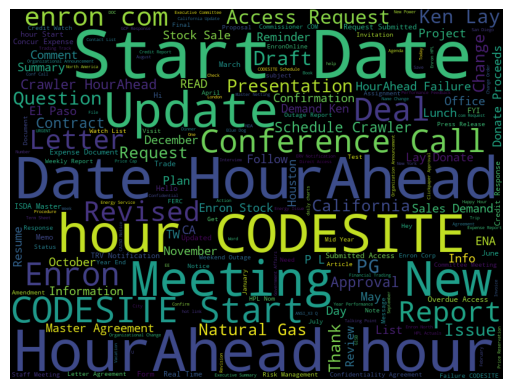

In [10]:
subjects = ' '.join(df['Subject'].values)   # Join all the `subjects` values store in dataframe into one string
fig, ax = plt.subplots()    # Create a figure and a set of subplots
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 200, stopwords = stopwords).generate(subjects)  # Create a word cloud object, stopwords are removed
ax.imshow(wc)
# This line turns off the axes around the word cloud. Removing the axes makes the visualization cleaner and more focused on the word cloud itself.
plt.axis('off')
plt.show()

#### Visualize the most common words in `content` columns

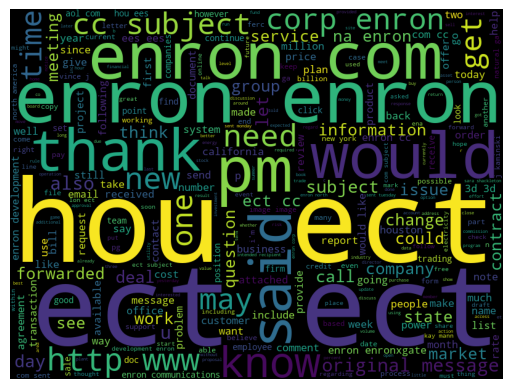

In [11]:
content = ' '.join(df['Content'].sample(5000).values) # Join all the `content` values store in dataframe into one string
fig, ax = plt.subplots()
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 300, stopwords = stopwords).generate(content)
ax.imshow(wc)
plt.axis('off')
plt.show()

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\AN
[nltk_data]     HONG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\AN
[nltk_data]     HONG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

'unzip' is not recognized as an internal or external command,
operable program or batch file.


### NLP

In [15]:
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()

In [17]:
# Tokenizing and lemmatizing the text to prepare for classification and sentiment analysis
text = []
for msg in df['Content'].values:
    msg_tokens = word_tokenize(msg)
    msg_tokens = [token.lower() for token in msg_tokens if token.isalpha()]
    msg_tokens = [word for word in msg_tokens if not word in stopwords]
    msg_tokens = [lemmatizer.lemmatize(word) for word in msg_tokens]
    
    text.append(msg_tokens)

In [18]:
text = [' '.join(message) for message in text]

In [78]:
# vectorizing the data using Tfidfvectorizer
vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000, stop_words = stopwords, norm = 'l1')
data = vectorizer.fit_transform(text)

c:\Users\AN HONG\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ahead', 'eol', 'fw', 'fwd', 'please'] not in stop_words.
  warnings.warn(


#### ML

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Assuming 'data' is the TF-IDF transformed data and 'df' is the DataFrame containing the labels
X = data
y = df['Folder']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    "SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=5),
    "ANN": MLPClassifier(hidden_layer_sizes=(10,))
}

# Initialize lists to store the scores
accuracy_scores = []
f1_scores = []
jaccard_scores = []

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    jaccard = jaccard_score(y_test, y_pred, average='macro')
    
    accuracy_scores.append((name, accuracy))
    f1_scores.append((name, f1))
    jaccard_scores.append((name, jaccard))
    
    print(f"{name} - Accuracy: {accuracy}, F1-score: {f1}, Jaccard-score: {jaccard}\n")

# Print the results
print("Accuracy Scores:", accuracy_scores)
print("F1 Scores:", f1_scores)
print("Jaccard Scores:", jaccard_scores)

Training SVM...


In [20]:
# Normalizing the data
data_norm = normalize(data)

In [22]:
# Decomposition of the data and decreasing alot of features
svd = TruncatedSVD(n_components = 2, n_iter = 10, random_state = 42)
datasvd = svd.fit_transform(data_norm)

In [23]:
datasvd.shape

(463903, 2)

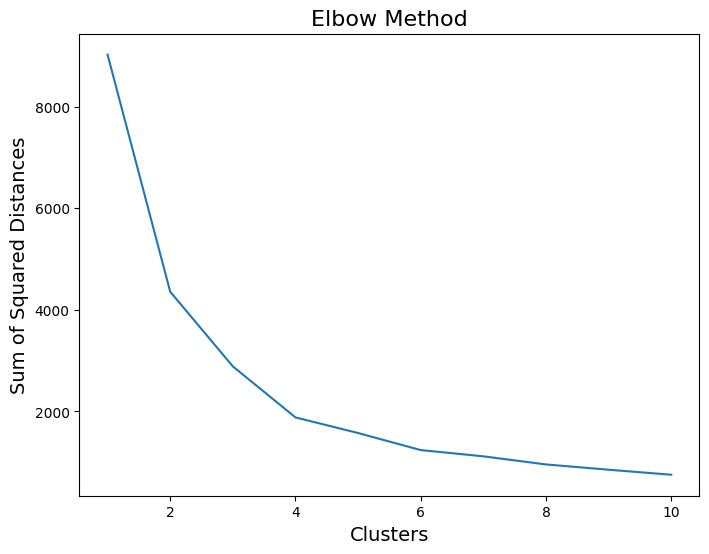

In [24]:
# Use the Elbow method to define the optimal number of clusters for kmeans clustering
max_iter = 1000
sumsquares = []
number_clusters = range(1,11)
for i in number_clusters:
    kmeans = KMeans(n_clusters = i, max_iter = max_iter, n_init = 'auto')
    kmeans.fit(datasvd)
    sumsquares.append(kmeans.inertia_)
plt.figure(figsize = (8,6))
plt.plot(number_clusters, sumsquares)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Sum of Squared Distances', fontsize = 14)
plt.title('Elbow Method', fontsize = 16)
plt.show()

In [25]:
n_clusters = 6
clf = KMeans(n_clusters = n_clusters,init = 'random', max_iter = max_iter, tol = 0.0001, algorithm = 'lloyd', n_init = 'auto', random_state = 42)
fittedkmeans = clf.fit_predict(datasvd)
centroids = clf.cluster_centers_

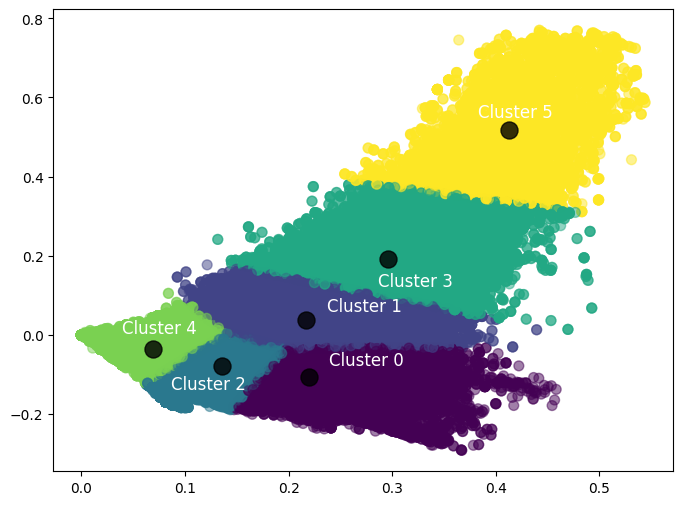

In [26]:
# A diagram showing the clusters
plt.figure(figsize = (8,6))
plt.scatter(datasvd[:,0], datasvd[:,1], c = fittedkmeans, s = 50, cmap = 'viridis', alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], s = 150, c = 'black', alpha = 0.8)
plt.annotate('Cluster 0', xy = (centroids[0][0], centroids[0][1]), xytext = (centroids[0][0] + 0.02, centroids[0][1] + 0.03), color = 'white', fontsize = 12)
plt.annotate('Cluster 1', xy = (centroids[1][0], centroids[1][1]), xytext = (centroids[1][0] + 0.02, centroids[1][1] + 0.02), color = 'white', fontsize = 12)
plt.annotate('Cluster 2', xy = (centroids[2][0], centroids[2][1]), xytext = (centroids[2][0] - 0.05, centroids[2][1] - 0.06), color = 'white', fontsize = 12)
plt.annotate('Cluster 3', xy = (centroids[3][0], centroids[3][1]), xytext = (centroids[3][0] - 0.01, centroids[3][1] - 0.07), color = 'white', fontsize = 12)
plt.annotate('Cluster 4', xy = (centroids[4][0], centroids[4][1]), xytext = (centroids[4][0] - 0.03, centroids[4][1] + 0.04), color = 'white', fontsize = 12)
plt.annotate('Cluster 5', xy = (centroids[5][0], centroids[5][1]), xytext = (centroids[5][0] - 0.03, centroids[5][1] + 0.03), color = 'white', fontsize = 12)

plt.show()

In [27]:
# extract top words in every cluster using the inverse_transform method
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1] #(10,5000)
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
        
    print()

Cluster 0: enron please ect subject pm message thanks would cc know sent http attached original let call need time may get 
Cluster 1: ect enron pm cc subject forwarded development enronxgate please thanks mark ee communication deal john vince know david would kay 
Cluster 2: enron please message subject would http thanks pm sent know original attached may time let call get need cc new 
Cluster 3: ect enron cc pm subject development forwarded enronxgate ee communication mark david tana vince john deal sara kay thanks mary 
Cluster 4: ect enron subject pm please cc thanks would message know forwarded sent attached deal development let need call mark meeting 
Cluster 5: ect enron cc pm subject development forwarded enronxgate ee communication mark david thanks vince john deal tana please kay sara 


### Anomaly Detection

In [29]:
from sklearn.metrics import pairwise_distances_argmin_min

# Calculate the distance of each point to its assigned cluster centroid
distances = pairwise_distances_argmin_min(datasvd, centroids)[1]

# Determine the threshold for anomalies
# For example, you can use the mean plus 2 standard deviations as the threshold
threshold = distances.mean() + 2 * distances.std()

# Identify anomalies
anomalies = df[distances > threshold]

# Print the anomalies
print(anomalies)

                             Date                     From  \
19      2000-09-26 12:07:00+00:00  phillip.allen@enron.com   
49      2000-09-06 11:46:00+00:00  phillip.allen@enron.com   
68      2000-08-28 13:40:00+00:00  phillip.allen@enron.com   
86      2000-12-13 13:40:00+00:00   paul.kaufman@enron.com   
89      2000-08-16 10:59:00+00:00  phillip.allen@enron.com   
...                           ...                      ...   
494730  2001-09-26 13:16:58+00:00    andy.zipper@enron.com   
494905  2000-12-11 14:15:00+00:00   david.fisher@enron.com   
495221  2001-11-13 20:16:52+00:00  john.zufferli@enron.com   
495348  2001-08-21 22:32:58+00:00  john.zufferli@enron.com   
495520  2001-12-21 20:44:08+00:00  john.zufferli@enron.com   

                                                       To  \
19                                   ina.rangel@enron.com   
49      thomas.martin@enron.com, mike.grigsby@enron.co...   
68      matthew.lenhart@enron.com, mike.grigsby@enron....   
86         

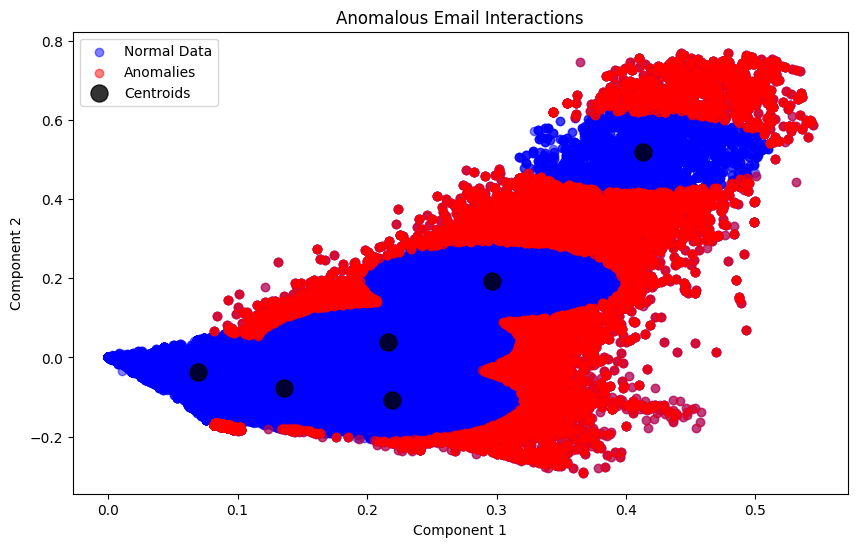

In [30]:
# Visualize the anomalies
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(datasvd[:, 0], datasvd[:, 1], c='blue', label='Normal Data', alpha=0.5)
ax.scatter(datasvd[distances > threshold, 0], datasvd[distances > threshold, 1], c='red', label='Anomalies', alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], s=150, c='black', alpha=0.8, label='Centroids')
ax.set_title('Anomalous Email Interactions')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.legend()
plt.show()

#### Feature Expansion and Anomaly Detection

In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest

# Assuming df is your DataFrame containing the email data

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by sender, receiver, and date
df = df.sort_values(by=['From', 'To', 'Date'])

# Calculate the time interval between consecutive emails from the same sender to the same receiver
df['Time_Diff'] = df.groupby(['From', 'To'])['Date'].diff().dt.total_seconds().fillna(0)

# Calculate the size of the email content
df['Email_Size'] = df['Content'].apply(len)

# Calculate the length of the email subject
df['Subject_Length'] = df['Subject'].apply(len)

# Display the enriched DataFrame
print(df[['From', 'To', 'Date', 'Time_Diff', 'Email_Size', 'Subject_Length']].head())
# Save the enriched DataFrame to a new CSV file
df.to_csv('enriched_emails.csv', index=False)
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the model to the data
iso_forest.fit(datasvd)

# Predict anomalies
df['Anomaly'] = iso_forest.predict(datasvd)

# Convert the anomaly labels to boolean (1 for anomaly, -1 for normal)
df['Anomaly'] = df['Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Display the anomalies
anomalies = df[df['Anomaly'] == 1]
print(anomalies)

# Save the anomalies to a new CSV file
anomalies.to_csv('anomalies_isolation_forest.csv', index=False)

                                 From  \
389093  'todd'.delahoussaye@enron.com   
281013  'todd'.delahoussaye@enron.com   
320556  'todd'.delahoussaye@enron.com   
281033  'todd'.delahoussaye@enron.com   
320565  'todd'.delahoussaye@enron.com   

                                                       To  \
389093  derek.bailey@enron.com, jean.bell@enron.com, r...   
281013  derek.bailey@enron.com, jean.bell@enron.com, r...   
320556  derek.bailey@enron.com, jean.bell@enron.com, r...   
281033  derek.bailey@enron.com, jean.bell@enron.com, r...   
320565  derek.bailey@enron.com, jean.bell@enron.com, r...   

                            Date  Time_Diff  Email_Size  Subject_Length  
389093 2001-10-24 13:50:26+00:00        0.0        2739              14  
281013 2001-11-20 16:01:44+00:00        0.0        3554              14  
320556 2001-11-20 16:01:44+00:00        0.0        3554              14  
281033 2001-11-21 16:41:36+00:00    88792.0         829              14  
320565 2001-11-2

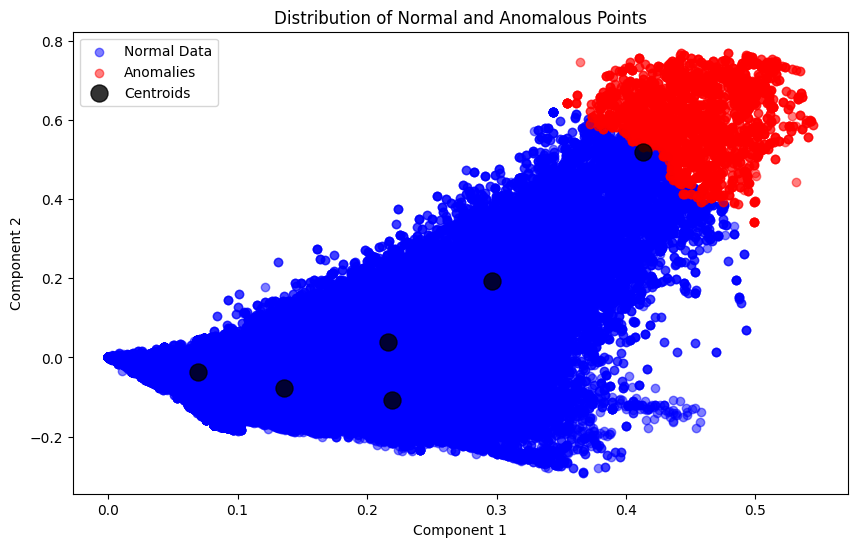

In [32]:
# Visualize the distribution of normal and abnormal points
fig, ax = plt.subplots(figsize=(10, 6))

# Plot normal points
normal_points = datasvd[df['Anomaly'] == 0]
ax.scatter(normal_points[:, 0], normal_points[:, 1], c='blue', label='Normal Data', alpha=0.5)

# Plot abnormal points
anomalous_points = datasvd[df['Anomaly'] == 1]
ax.scatter(anomalous_points[:, 0], anomalous_points[:, 1], c='red', label='Anomalies', alpha=0.5)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], s=150, c='black', alpha=0.8, label='Centroids')

# Set plot title and labels
ax.set_title('Distribution of Normal and Anomalous Points')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.legend()

# Show plot
plt.show()

### ML method comparison